# Project Machine Learning: Group 25
### Peter Bonnarens, Lennert Franssens & Philip Kukoba

# Sprint 1 : Tabular Data

### Possible tasks:
* Thorough exploratory data analysis, e.g.:
    * Are there substantial price differences between neighbourhoods ?
    * Are there hosts with more than one listing ? How does this impact the price ?
    * What is the correlation between the review score and the price ?
    * ...

    Not enough to just show a plot! Clearly describe WHAT question you investigated, WHY you think this is a relevant question
    and WHAT you deduce/conclude from the results of your data analysis

* Are there outliers ?
* A new Airbnb owner needs to pick an appropriate price:
    * Train a model to predict the price based on a selection of features
    * Find the most similar listings
    
* ...

# Table of work (who did what)

<br>

## Exploratory Data Analysis (EDA)
|                   	| EDA step 1 	| EDA step 2A 	| EDA step 2B 	| EDA step 2C 	| EDA step 2D 	| EDA step 3A 	| EDA step 3B 	|
|:-----------------:	|:----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|
|  Peter Bonnarens  	|      X     	|             	|      X      	|             	|             	|             	|             	|
| Lennert Franssens 	|      X     	|      X      	|      X      	|             	|      X      	|      X       	|             	|
|   Philip Kukoba   	|      X     	|             	|             	|      X      	|             	|             	|             	|

<br>

## Linear Regression Model (LR)
|                   	| LR step 1 	| LR step 2 	| LR step 3 	| LR step 4 	|
|:-----------------:	|:---------:	|:---------:	|:---------:	|:---------:	|
|  Peter Bonnarens  	|     X     	|           	|           	|     X     	|
| Lennert Franssens 	|           	|           	|           	|           	|
|   Philip Kukoba   	|           	|           	|           	|           	|

<br>

## K Nearest Neighbors Model (KNN)
|                   	| KNN step 1 	| KNN step 2 	| KNN step 3 	| KNN step 4 	|
|:-----------------:	|:----------:	|:----------:	|:----------:	|:----------:	|
|  Peter Bonnarens  	|            	|            	|            	|            	|
| Lennert Franssens 	|     X      	|     X       	|     X       	|     X      	|
|   Philip Kukoba   	|            	|            	|            	|            	|

# Exploratory Data Analysis (EDA)

## Step 1: imports & loading the dataset

In [28]:
# imports
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

from sklearn.neighbors import KDTree
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# figure size in inches
rcParams['figure.figsize'] = 20,16

%matplotlib inline

# loading the dataset into pandas dataframe
listings = pd.read_csv("data/listings.csv")

## Step 2: preprocessing

### 2A : Shift rows
We noticed that some rows in the dataset contained data that was shifted 1 column to the right starting from the 'host_id' column. Instead of removing these rows from the dataset, we decided to shift these rows 1 column back to the left.

In [29]:
# find lines to shift and add them to a mask - we've found that some lines are shifted 1 to the right beginning on the host_id column (that now contains garbage data)
shifted_lines = listings[pd.to_numeric(listings["host_verifications"], errors='coerce').notnull()].id
mask = listings['id'].isin(shifted_lines)

# shift lines 1 to the left
listings.loc[mask, 'host_id':'reviews_per_month'] = listings.loc[mask, 'host_id':'reviews_per_month'].shift(-1, axis=1)


### MERK OP: er zijn een paar rijen verschoven (bepaalde kolom die weg is ofzo): shift deze rijen!!!

1. host_response_time en host_response_rate: regex om tijdsinterval te kennen, slechte waarden van host_response_time vervangen door juiste waarde in host_response_rate (zie print(listings[ (~listings["host_response_rate"].isnull()) & (~listings["host_response_rate"].str.match('.*%', na=False)) ]) ) en percentage teken bij host_response_rate wegdoen - is omgezet naar een rating (gemakkelijker)
2. host acceptance rate: % wegdoen en omzetten naar float. - % is weggedaan, nog omzetten naar float.. (kan nan niet omzetten naar float)
3. host total listings count: omzetten naar float
4. host verifications: omzetten naar lengte van de array om te kijken op hoeveel manieren een host kan geverifieerd worden (meer trustworthy?)
5. host has profile pic: omzetten naar 0 of 1 (misschien meer geboekt als wel profile pic?)
6. host identity verified: omzetten naar 0 of 1 (misschien meer geboekt als verified?)
8. last_review: datum omzetten naar ???

### 2B : Feature subset selection
Before we start cleaning up the data, we first extract the features we think will be useful to explore during this sprint.

In [30]:
# filter columns
listings = listings[["id", "name", "host_id", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_has_profile_pic","host_identity_verified", "neighbourhood_cleansed", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "price", "minimum_nights", "maximum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"]]
# listings.head()

### 2C : Host response time/rate

In [31]:
# host_response_time
# 0 = best resposne time, 1,2... worse
# listings["host_response_time"].unique()

listings["host_response_time"] = [0 if x == 'within an hour' 
                                    else 1 if x == 'within a few hours' 
                                    else 2 if x == 'within a day' 
                                    else 3 if x == 'a few days or more' 
                                    else None 
                                    for x in listings["host_response_time"]]

# convert room types to integers
listings["room_type"] = [0 if x == 'Private room' 
                            else 1 if x == 'Entire home/apt' 
                            else 2 if x == 'Hotel room' 
                            else 3 if x == 'Shared room' 
                            else None 
                            for x in listings["room_type"]]

#host_response_rate strip trailing % char
listings["host_response_rate"] = listings['host_response_rate'].str.rstrip('%').astype('float') / 100.0

### 2D: Convert some column types

In [32]:
# convert to float
listings['price'] = listings['price'].replace('[\$,)]', '', regex=True).astype(float)

# convert to float
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# convert to number of verification types
listings['host_verifications'] = listings['host_verifications'].apply(eval).apply(lambda x: len(x))

# convert t and f to 1 and 0
listings["host_has_profile_pic"] = listings["host_has_profile_pic"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["host_identity_verified"] = listings["host_identity_verified"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)
listings["instant_bookable"] = listings["instant_bookable"].apply(lambda x: 1 if x == 't' else 0 if x == 'f' else None)

## Step 3 : plots

### 3A : Correlation matrix

<AxesSubplot:>

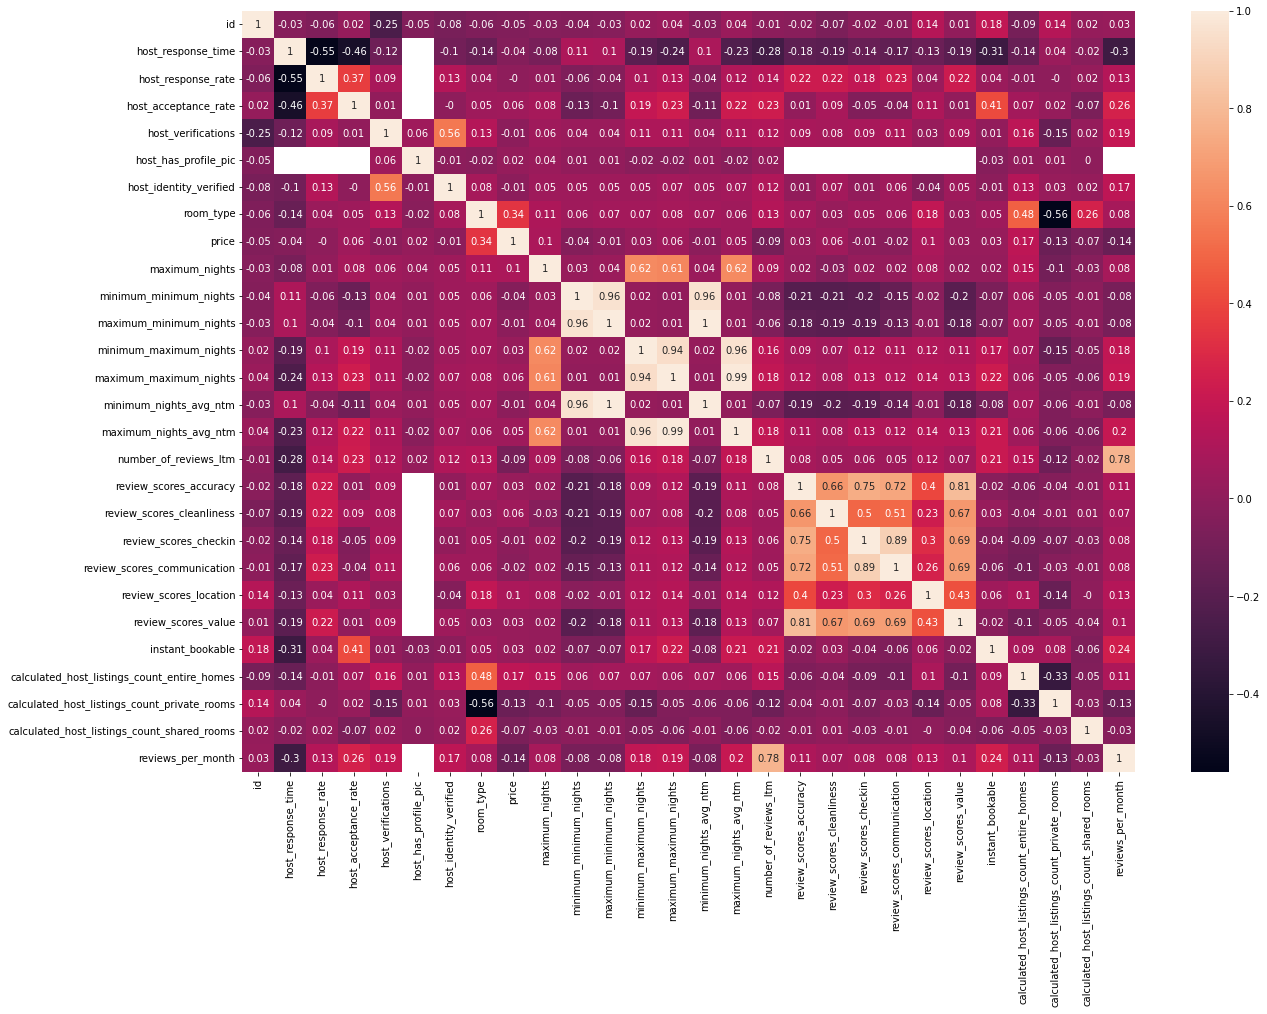

In [33]:
correlation_matrix = listings.corr().round(2)
plt.figure(figsize=(20,14))
sns.heatmap(data=correlation_matrix, annot=True)

### 3B: Distribution and pairplot

c:\users\p_kuk\scoop\apps\python\current\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
c:\users\p_kuk\scoop\apps\python\current\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
c:\users\p_kuk\scoop\apps\python\current\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-leve

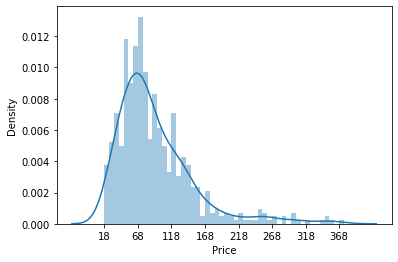

In [34]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

dataset = listings[["price", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_total_listings_count", "host_verifications", "host_has_profile_pic","host_identity_verified", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "number_of_reviews", "number_of_reviews_ltm", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "instant_bookable", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"]]
dataset.drop(['bathrooms'], inplace=True, axis=1)
dataset.drop(['last_review'], inplace=True, axis=1)

dataset.dropna(inplace=True)
dataset = dataset.apply(pd.to_numeric)

#dataset.head()
#dataset.describe()
sns.distplot(dataset.price, bins=50)
plt.xlabel("Price")
plt.xticks(np.arange(min(dataset.price.to_numpy()), max(dataset.price.to_numpy()), 50.0))
plt.show()

# TODO: uncomment (takes up to 3 minutes!!!)
#sns.pairplot(dataset, hue="price", vars=["host_total_listings_count", "host_verifications", "accommodates", "bedrooms", "beds", "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"])

# TODO: find some interesting plots
#sns.catplot(x="ca", y="age", kind="swarm", data=dataset, hue="price")
#sns.catplot(x="thal", y="chol", kind="swarm", data=dataset, hue="price")

# Linear Regression Model

## Step 1 : Train - Test - Split

In [35]:
from sklearn.model_selection import train_test_split

# TODO: insert chosen features into X
X = pd.concat((), axis=1)
Y = listings["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

ValueError: No objects to concatenate

## Step 2: Normalizing the data

In [36]:
# TODO
# formule: x-xmin/xmax-xmin

## Step 3 : Training the model

In [37]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_train_predict = lin_model.predict(X_train)
y_test_predict = lin_model.predict(X_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Step 4 : Measure the performance of the model

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

# model evaluation for training set
n_train = len(X_train)  # sample size
p_train = len(X_train.columns)  # number of independent variables
R2_train = r2_score(Y_train, y_train_predict)
RMSE_train = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
# use the adjusted R² score to counter accidental increase of score with number of input features.
adj_R2_train = 1 - ((1-R2_train) * (n_train-1)/(n_train-p_train-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model train performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_train))
print('R2 score is {}'.format(R2_train))
print('adjusted R2 score is {}'.format(adj_R2_train))
print("\n")

# model evaluation for testing set
n_test = len(X_test)
p_test = len(X_test.columns)
R2_test = r2_score(Y_test, y_test_predict)
RMSE_test = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
adj_R2_test = 1 - ((1-R2_test) * (n_test-1)/(n_test-p_test-1))   #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)

print("Model test performance")
print("--------------------------------------")
print('RMSE is {}'.format(RMSE_test))
print('R2 score is {}'.format(R2_test))
print('adjusted R2 score is {}'.format(adj_R2_test))
print("\n")


print("Model parameters")
print("--------------------------------------")
print(lin_model.coef_)
print(lin_model.intercept_)

NameError: name 'y_train_predict' is not defined

# Random Forest Regression

## Step 1: Setup

In [42]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

#helper functions

def run_predictions(tree, x):
    predictions = []
    for index, sample in x.iterrows():
        prediction = tree.predict(sample)
        predictions.append(prediction)
    return predictions
    
def visualize_results(predictions, ground_truth):
    
    plt.scatter(ground_truth, predictions, alpha=0.5)
    plt.xlabel("Ground truth price")
    plt.ylabel("Predicted price")
    plt.show()
    
    rmse = (np.sqrt(mean_squared_error(ground_truth, predictions)))
    r2 = r2_score(ground_truth, predictions)
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

## Step 2: Split dataset

In [43]:
#Split dataset in training and test set 
#TODO choose features more wisely

ds_copy=dataset
X = ds_copy.drop(['price'], axis=1)
Y = ds_copy["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)


## Step 3: Run random forest regression

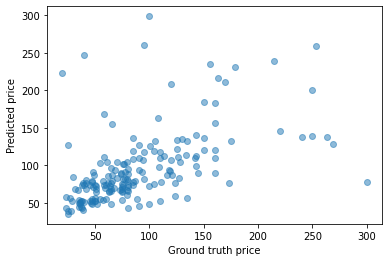

RMSE is 49.53971541760302
R2 score is 0.1390716018295185


In [44]:
regr = RandomForestRegressor(max_depth=8, random_state=0)
regr.fit(X_train, Y_train)

predictions = regr.predict(X_test)

visualize_results(predictions, Y_test)

It is clear from the RMSE and R2 measurements that the random forest regression does not deliver a good result.

# K Nearest Neighbors Model

## Step 1 : Use one-hot encodings

In [ ]:
# TODO: predict without score values (only initial values can be used for this analysis)
# Replace categorical features with one-hot encodings
a = pd.get_dummies(dataset['host_response_time'], prefix = "hrt")
b = pd.get_dummies(dataset['room_type'], prefix = "rt")

frames = [dataset, a, b]
dataset = pd.concat(frames, axis = 1)

dataset.drop(['host_response_time'], inplace=True, axis=1)
dataset.drop(['room_type'], inplace=True, axis=1)

dataset.head()

## Step 2: Normalizing and splitting the data

In [ ]:
columns = ["host_total_listings_count", "host_verifications", "accommodates", "bedrooms", "beds", "number_of_reviews", "number_of_reviews_ltm", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"]
dataset[columns] = (dataset[columns] - np.min(dataset[columns])) / (np.max(dataset[columns]) - np.min(dataset[columns])).values
dataset.describe()
#dataset.dtypes

# Split data in a training and test set
y = dataset.price.values
x = dataset.drop(['price'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

## Step 3 : Training the model

In [ ]:
# The algorithm
class MyKNeighborsClassifier:
    def __init__(self, k):
        self.k = k
    def fit(self, x, y):
        self.tree = KDTree(x)
        self.y = y
    def predict(self, x):
        _, ind = self.tree.query(x, k=self.k)
        return self.y[ind].mean(axis=1)


knn = MyKNeighborsClassifier(3)
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)

predictions

## Step 4: Measure the performance of the model

In [ ]:
# TODO: Fix these tests!!! Use the y_test to compare to the predictions values.
#accuracy = (predictions == y_test).mean()

# TODO: Remove outliers (less common listings) - where price > 170
accuracy = np.where((predictions > y_test - 20) & (predictions < y_test + 20), True, False).mean()
print(accuracy)

#TP = (predictions[y_test == 1] == 1).sum()
#print(TP)

#TN = (predictions[y_test == 0] == 0).sum()
#print(TN)

#FP = (predictions[y_test == 1] == 0).sum()
#print(FP)

#FN = (predictions[y_test == 0] == 1).sum()
#print(FN)

#accuracy = (TP+TN)/(TP+TN+FN+FP)
#print(accuracy)

#precision = TP / (TP + FP)
#print(precision)

#recall = TP / (TP + FN)
#print(recall)

#F1 = 2 *  (precision*recall)/(precision+recall)
#print(F1)

#accuracies = []
#for k in range(1, 50):
#    knn = MyKNeighborsClassifier(k)
#    knn.fit(x_train, y_train)
#    predictions = knn.predict(x_test)  > 0.5
#    accuracies.append((predictions == y_test).mean())
#plt.plot(accuracies)


#knn = MyKNeighborsClassifier(5)
#knn.fit(x_train, y_train)
#predictions = knn.predict(x_test)

#fpr, tpr, thresholds = roc_curve(y_test, predictions)
#roc_auc = auc(fpr, tpr)
        
#plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

#for x, y, txt in zip(fpr, tpr, thresholds):
#    plt.annotate(np.round(txt,2), (x, y-0.04))
    
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
#plt.legend(loc="lower right")